Masks play a crucial role in protecting the health of individuals against respiratory diseases, as is one of the few precautions available for COVID-19 in the absence of immunization. With this dataset, it is possible to create a model to detect people wearing masks, not wearing them, or wearing masks improperly.
This dataset contains 853 images belonging to the 3 classes, as well as their bounding boxes in the PASCAL VOC format.
The classes are:

With mask;
Without mask;
Mask worn incorrectly.


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches
import os

In [2]:
 ! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d andrewmvd/face-mask-detection

face-mask-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [10]:
!unzip face-mask-detection.zip

Archive:  face-mask-detection.zip
  inflating: annotations/maksssksksss0.xml  
  inflating: annotations/maksssksksss1.xml  
  inflating: annotations/maksssksksss10.xml  
  inflating: annotations/maksssksksss100.xml  
  inflating: annotations/maksssksksss101.xml  
  inflating: annotations/maksssksksss102.xml  
  inflating: annotations/maksssksksss103.xml  
  inflating: annotations/maksssksksss104.xml  
  inflating: annotations/maksssksksss105.xml  
  inflating: annotations/maksssksksss106.xml  
  inflating: annotations/maksssksksss107.xml  
  inflating: annotations/maksssksksss108.xml  
  inflating: annotations/maksssksksss109.xml  
  inflating: annotations/maksssksksss11.xml  
  inflating: annotations/maksssksksss110.xml  
  inflating: annotations/maksssksksss111.xml  
  inflating: annotations/maksssksksss112.xml  
  inflating: annotations/maksssksksss113.xml  
  inflating: annotations/maksssksksss114.xml  
  inflating: annotations/maksssksksss115.xml  
  inflating: annotations/maksssk

In [11]:
def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([image_id])
        # Annotation is in dictionary format
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target

DATASET: https://www.kaggle.com/datasets/andrewmvd/face-mask-detection

In [12]:
imgs = list(sorted(os.listdir("/content/images")))

In [13]:
labels = list(sorted(os.listdir("/content/annotations")))

In [12]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir("/content/images")))
        # self.labels = list(sorted(os.listdir("/content/annotations")

    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join("/content/images", file_image)
        label_path = os.path.join("/content/annotations", file_label)
        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [13]:
data_transform = transforms.Compose([
        transforms.ToTensor(), 
    ])

In [14]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform)
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=4, collate_fn=collate_fn)

In [15]:
torch.cuda.is_available()

True

Model Making

Fast R-CNN :is an object detector that was developed solely by Ross Girshick, a Facebook AI researcher and a former Microsoft Researcher. Fast R-CNN overcomes several issues in R-CNN. As its name suggests, one advantage of the Fast R-CNN over R-CNN is its speed.

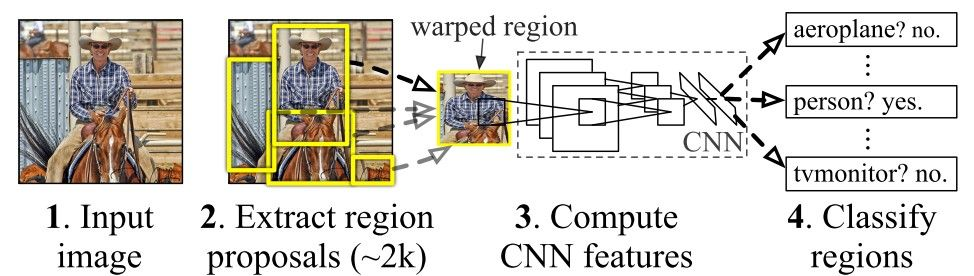

In [16]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [17]:
model = get_model_instance_segmentation(3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [18]:
from google.colab import output
output.enable_custom_widget_manager()

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]], device='cuda:0'), 'labels': tensor([0, 1, 0], device='cuda:0'), 'image_id': tensor([0], device='cuda:0')}, {'boxes': tensor([[321.,  34., 354.,  69.],
        [224.,  38., 261.,  73.],
        [299.,  58., 315.,  81.],
        [143.,  74., 174., 115.],
        [ 74.,  69.,  95.,  99.],
        [191.,  67., 221.,  93.],
        [ 21.,  73.,  44.,  93.],
        [369.,  70., 398.,  99.],
        [ 83.,  56., 111.,  89.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0'), 'image_id': tensor([1], device='cuda:0')}, {'boxes': tensor([[ 68.,  42., 105.,  69.],
        [154.,  47., 178.,  74.],
        [238.,  34., 262.,  69.],
        [333.,  31., 366.,  65.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 2], device='cuda:0'), 'image_id': tensor([2], device='cuda:0')}, {'boxes': tensor([[ 52.,  53.,  73.,  76.],
        [ 72.,  53.,  92.,  75.],
  

Training the Model

In [20]:
num_epochs = 30
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        #print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
    print(epoch_loss)

tensor(85.9340, device='cuda:0', grad_fn=<AddBackward0>)
tensor(59.3711, device='cuda:0', grad_fn=<AddBackward0>)
tensor(48.9931, device='cuda:0', grad_fn=<AddBackward0>)
tensor(43.1930, device='cuda:0', grad_fn=<AddBackward0>)
tensor(41.4658, device='cuda:0', grad_fn=<AddBackward0>)
tensor(38.8802, device='cuda:0', grad_fn=<AddBackward0>)
tensor(34.4028, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.1153, device='cuda:0', grad_fn=<AddBackward0>)
tensor(28.2254, device='cuda:0', grad_fn=<AddBackward0>)
tensor(27.6838, device='cuda:0', grad_fn=<AddBackward0>)
tensor(24.7748, device='cuda:0', grad_fn=<AddBackward0>)
tensor(24.4324, device='cuda:0', grad_fn=<AddBackward0>)
tensor(25.6724, device='cuda:0', grad_fn=<AddBackward0>)
tensor(24.8961, device='cuda:0', grad_fn=<AddBackward0>)
tensor(24.0996, device='cuda:0', grad_fn=<AddBackward0>)
tensor(21.3726, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22.7406, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22.1760, device='cuda:0'

In [21]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [22]:
model.eval()
preds = model(imgs)
preds

[{'boxes': tensor([[185.7214, 100.0279, 226.4881, 143.6081],
          [  9.8036, 148.1481,  48.0596, 225.4525]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1], device='cuda:0'),
  'scores': tensor([0.9949, 0.0619], device='cuda:0', grad_fn=<IndexBackward0>)},
 {'boxes': tensor([[225.7898,  38.2834, 258.9639,  74.3806],
          [ 22.4340,  73.4536,  42.7448,  92.4964],
          [319.7242,  33.9577, 353.1004,  70.7327],
          [145.3352,  77.5801, 172.6765, 112.7546],
          [196.9935,  66.8837, 215.4855,  93.1851],
          [298.8196,  59.2261, 313.7440,  80.1546],
          [369.2751,  72.3106, 387.8305,  93.6451],
          [356.9048,  58.9638, 368.0542,  76.9615]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 2, 1], device='cuda:0'),
  'scores': tensor([0.9953, 0.9925, 0.9904, 0.9847, 0.9698, 0.9665, 0.1776, 0.1570],
         device='cuda:0', grad_fn=<IndexBackward0>)},
 {'boxes': tensor([[ 73.0

Function to plot image

In [32]:
def plot_image(img_tensor, annotation):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for box in annotation["boxes"]:
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()


Prediction
Target


TypeError: ignored

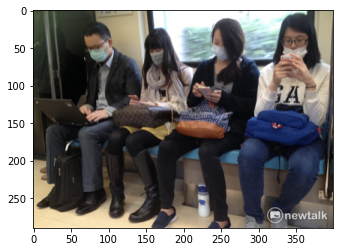

In [34]:
print("Prediction")
plot_image(imgs[6], preds[6])
print("Target")
plot_image(imgs[6], annotations[6])

In [ ]:
torch.save(model.state_dict(),'model.pt')

In [ ]:
model2 = get_model_instance_segmentation(3)

Saving the Model

In [ ]:
model2.load_state_dict(torch.load('model.pt'))
model2.eval()
model2.to(device)

Load Model:

In [ ]:
pred2 = model2(imgs)

In [ ]:
print("Predict with loaded model")
plot_image(imgs[3], pred2[3])